## Teacher-Student Learning with JAX

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
import matplotlib.pyplot as plt

from utils import load_plot_config
from jax.scipy.special import erf
load_plot_config()

## We will focus on the two layer neural network from Goldt et al. (2019)
We start by defining a two layer teacher network with erf activation function
$$ f(x) = V^{*} \text{erf}\left(\frac{W^{*} x}{\sqrt{N}}\right) $$

with $V^{*}\in \mathbb{R}^{1 \times M}$ and $W^{*}\in \mathbb{R}^{M\times N}$, $N$ being the input dimension and $M$ the number of hidden units, and the error function $$\text{erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{\frac{x}{\sqrt{2}}}e^{-t^{2}}dt$$

In [9]:
@jit
def error_function(x):
    return erf(x/jnp.sqrt(2.0))

@jit
def error_function_derivative(x):
    return 2.0*jnp.exp(-0.5*x**2)/jnp.sqrt(2.0*jnp.pi)

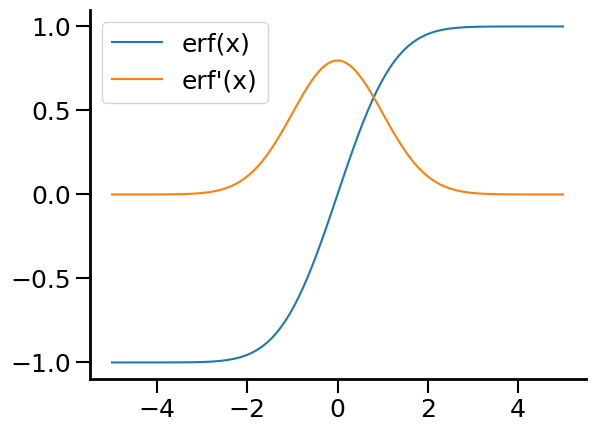

In [10]:
x = jnp.linspace(-5, 5, 100)
plt.plot(x, error_function(x), label='erf(x)')
plt.plot(x, error_function_derivative(x), label='erf\'(x)')
plt.legend()
plt.show()

In [11]:
@jit
def erf_net_predict(W2, W1, x, input_dim):
    linear_hidden = jnp.dot(W1, x)/jnp.sqrt(input_dim)
    hidden_layer = error_function(linear_hidden)
    output = jnp.dot(W2, hidden_layer)
    return output

@jit
def batch_erf_net_predict(W2, W1, x, input_dim):
    return vmap(erf_net_predict,
                in_axes=(None, None, 0, None))(W2, W1, x, input_dim)

@jit
def mse_loss(preds, target):
    return jnp.mean(jnp.square(preds - target))/2.0

@jit
def erf_net_loss(W2, W1, x, y, input_dim):
    preds = batch_erf_net_predict(W2, W1, x, input_dim)
    return mse_loss(preds, y)

@jit
def erf_net_update(W2, W1, x, y, lr, input_dim):
    loss = mse_loss(W2, W1, x, y, input_dim)
    grads = grad(mse_loss, argnums=(0, 1))(W2, W1, x, y, input_dim)
    W2_update = - lr * grads[0]/input_dim
    W1_update = - lr * grads[1]
    W2_next = W2 + W2_update
    W1_next = W1 + W1_update
    return W2_next, W1_next, W2_update, W1_update, loss

class ErfTwoLayerNet(object):

    def __init__(self, W, V, learning_rate=1e-3, weight_scale=1e-5):
        self.W1 = W
        self.W2 = V
        self.lr = learning_rate
        self.init_weight_scale = weight_scale
        
    def predict(self, x):
        return erf_net_predict(self.W2, self.W1, x, self.input_dim)

    def batch_predict(self, x):
        return batch_erf_net_predict(self.W2, self.W1, x, self.input_dim)

    def loss(self, x, y):
        return mse_loss(self.W2, self.W1, x, y, self.input_dim)

    def update(self, x, y):
        self.W1, self.W2, self.last_W2_update, self.last_W1_update, loss = ErfTwoLayerNet.erf_net_loss(self.W2, self.W1, x, y, self.lr, self.input_dim)
        return loss

## Defining teacher parameters

In [13]:
input_dim = 784
hidden_dim = 100
output_dim = 1
initial_weight_scale = 1e-5

W_teacher = np.random.normal(0, initial_weight_scale, (hidden_dim, input_dim))
V_teacher = np.random.normal(0, initial_weight_scale, (output_dim, hidden_dim))

print(W_teacher.shape, V_teacher.shape)

(100, 784) (1, 100)
